In [352]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms,datasets,models
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [353]:
device

device(type='cuda')

In [354]:
train_set = datasets.MNIST('./data',train=True,download=False)
test_set = datasets.MNIST('./data',train=False,download=False)
train_img = train_set.data.numpy()
test_img = test_set.data.numpy()
train_label = train_set.targets.numpy()
test_label = test_set.targets.numpy()
train_img = train_img.reshape(-1, 28, 28,1)
test_img = test_img.reshape(-1, 28, 28,1)

In [355]:
class block(nn.Module):
    def __init__(self,in_channel,intermediate_channel,downsample=None,stride=1):
        super().__init__()
        self.expansion = 4
        self.block1 = nn.Sequential(
                    nn.Conv2d(in_channel,intermediate_channel,3,stride,1).to(device),
                    nn.BatchNorm2d(intermediate_channel).to(device),
                    nn.ReLU()
                )
        self.block2 = nn.Sequential(
                    nn.Conv2d(intermediate_channel,intermediate_channel,3,1,1).to(device),
                    nn.BatchNorm2d(intermediate_channel).to(device),
                    nn.ReLU()
                )
        self.downsample = downsample
        self.stride = stride
    def forward(self,x):
        initial = x
        x = self.block1(x)
        x = self.block2(x)
        if self.downsample is not None:
            initial = self.downsample(initial)
        x += initial
        x = F.relu(x)
        return x

In [356]:
class ResNet(nn.Module):
    def __init__(self,img_channel,layers,block,classes):
        super().__init__()
        self.img_channel = img_channel
        self.in_channel = 64 
        self.initial_layer = nn.Sequential(
                                    nn.Conv2d(self.img_channel,self.in_channel,kernel_size=7,stride=2,padding=3).to(device),
                                    nn.BatchNorm2d(self.in_channel).to(device),
                                    nn.MaxPool2d(kernel_size=3,stride=2,padding =1)
                                )
        self.layer_1 = self.create_layer(block,layers[0],64,stride=1)
        self.layer_2 = self.create_layer(block,layers[1],128,stride=2)
        self.layer_3 = self.create_layer(block,layers[2],256,stride=2)
        self.layer_4 = self.create_layer(block,layers[0],512,stride=2)
        
        self.fc_layer = nn.Sequential(
                                        nn.Flatten(),
                                        nn.Linear(512,classes).to(device)
                                        )
        
    def forward(self,x):
        x = self.initial_layer(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
#         x = x.view(x.shape[0],512)
        x = self.fc_layer(x)
        return x
    
    def create_layer(self,block,residual_blocks,intermediate_channel,stride):
        identity_downsample = None
        layers = []
        if stride!=1 or self.in_channel!=intermediate_channel:
            identity_downsample = nn.Sequential(
                                nn.Conv2d(self.in_channel,intermediate_channel,1,stride).to(device),
                                nn.BatchNorm2d(intermediate_channel).to(device)
            )
        layers.append(block(self.in_channel,intermediate_channel,identity_downsample,stride))
        self.in_channel = intermediate_channel
        for i in range(1,residual_blocks):
            layers.append(block(self.in_channel,intermediate_channel))
        return nn.Sequential(*layers)
resnet = ResNet(1,[1,1,1,1],block,10)
resnet

ResNet(
  (initial_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer_1): Sequential(
    (0): block(
      (block1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (block2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (layer_2): Sequential(
    (0): block(
      (block1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1,

In [357]:
train_images = torch.Tensor(train_img).view(train_img.shape[0],1,28,28).to(device)
test_images = torch.Tensor(test_img).view(test_img.shape[0],1,28,28).to(device)
train_label = torch.Tensor(train_label)
test_label = torch.Tensor(test_label)

In [358]:
train_label_one_hot = F.one_hot(train_label.type(torch.int64),10)
test_label_one_hot = F.one_hot(test_label.type(torch.int64),10)

In [359]:
batch_size = 200
epoch = 5
lr = 0.001

In [360]:
optimiser = torch.optim.Adam(resnet.parameters(),lr=lr)
optimiser

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [361]:
loss_function = nn.MSELoss()
loss_function

MSELoss()

In [362]:
loss_list = []

In [379]:
def train(X,Y):
    for e in range(0,epoch):
        batch = torch.randperm(X.shape[0]).to(device)
        loss_val = 0
        true_val = 0
        total = 0
        for i in range(0,X.shape[0],batch_size):
            train_img = X[batch[i:i+batch_size]]
            train_lab = Y[batch[i:i+batch_size]]
            output = resnet(train_img)
            optimiser.zero_grad()
            loss_val = loss_function(output,train_lab)
            loss_val.backward()
            loss_list.append(loss_val.item())
            optimiser.step()
            for idx,j in enumerate(output):
                if(torch.argmax(j) == torch.argmax(Y[idx])):
                    true_val += 1
                total += 1
        print("For epoch ",e+1," Loss is: ",true_val/total)

In [380]:
train(train_images.to(device),train_label_one_hot.type(torch.float).to(device))

For epoch  1  Loss is:  0.10195
For epoch  2  Loss is:  0.10165
For epoch  3  Loss is:  0.10216666666666667
For epoch  4  Loss is:  0.10016666666666667
For epoch  5  Loss is:  0.10043333333333333


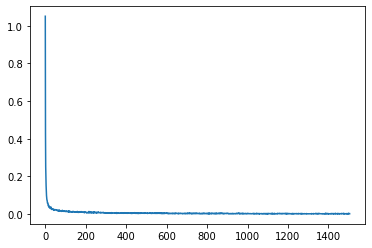

In [381]:
import matplotlib.pyplot as plt
plt.plot(loss_list)

In [404]:
check_list = []
true_val_list = []
def test(X,Y):
    with torch.no_grad():
        batch = torch.randperm(X.shape[0]).to(device)
        loss_val = 0
        true_val = 0
        total = 0
        for i in range(0,X.shape[0],batch_size):
            train_img = X[batch[i:i+batch_size]]
            train_lab = Y[batch[i:i+batch_size]]
            output = resnet(train_img)
            loss_val = loss_function(output,train_lab)
            for idx,j in enumerate(output):
                if(torch.argmax(j) == torch.argmax(Y[idx])):
                    true_val += 1
                    true_val_list.append(torch.argmax(Y[idx]))
                total += 1
        check_list.append(batch)
        check_list.append(output)
        print("For test,Loss is: ",true_val/total)

In [405]:
test(test_images.to(device),test_label_one_hot.type(torch.float).to(device))

For test,Loss is:  0.1016


Given number is:  5


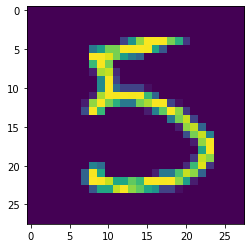

In [431]:
img_fin = test_images[0:20].view(20,1,28,28)
fin_img = resnet(img_fin)
print("Given number is: ",torch.argmax(fin_img[15]).item())
img = test_img[15]
plt.imshow(img)